In [2]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/iprovilkov/data/JUNO/notebooks/')

In [3]:
from data_utils.data_processing import get_data_2dprojection
from data_utils.data_generator import DataGenerator

Using TensorFlow backend.


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'
rg = np.arange(0,100001,20000)
MAXR = 17200

In [8]:
rg

array([     0,  20000,  40000,  60000,  80000, 100000])

In [4]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [32]:
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
import keras.layers as L
from keras.models import Sequential
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import keras.layers as L
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.engine.input_layer import Input
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [33]:
model = Sequential()
model.add(L.Conv2D(filters= 32, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters= 64, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3), activation='elu'))
#model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(1024, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
#model.add(L.Dropout(0.3))
model.add(L.Dense(512, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
model.add(L.Dense(256, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
model.add(L.Dense(1))

In [34]:
opt = Adam(decay=1e-4)

In [35]:
edge_size0 = 226
edge_size1 = 112
inputs = Input(shape=(edge_size0,edge_size1,2))

In [36]:
model.compile(loss='mean_squared_error', optimizer=opt)

In [37]:
model.build(input_shape=(None, edge_size0,edge_size1,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 110, 32)      608       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 55, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 110, 53, 64)       18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 55, 26, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 53, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 26, 12, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 10, 256)       295168    
__________

In [38]:
logdir = 'Simple_CNN_E.csv'

In [39]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(logdir, append=True, separator=';')
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [40]:
TRAIN_DIR = '~/data/data_dir/'
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [41]:
epochs = [5,5,5,3,3,3,1,1,1,1,1,1,1]

In [42]:
rg

array([    0, 20000, 40000, 60000, 80000])

In [43]:
X_test = np.load(LTRAIN + '_' + str(rg[-2]) +'without_noise_sin.npy')

In [44]:
y_test = tr_true_info[(tr_true_info['evtID'] >= rg[-2]) 
                     & (tr_true_info['evtID'] < rg[-1])]
mask = (y_test.R <= MAXR)
X_test = X_test[mask]
y_test = y_test[mask][['E']].values

In [45]:
def scale(X):
    X[:,:,:,1] /= 20 

In [49]:
def scaler(X,y):
    X[:,:,:,1] /= 20 

In [46]:
scale(X_test)

In [47]:
import gc
for i in range(len(epochs)):
    for start, end in zip(rg[:-2], rg[1:-1]):
        print("ITERATION: ", i)
        data_lpmt_cur = np.load(LTRAIN + '_' + str(start) +'without_noise_sin.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt_cur = data_lpmt_cur[mask]
        y_cur = ys[mask][['E']].values
        #Scale
        scale(data_lpmt_cur)
        
        #X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(data_lpmt_cur, y_cur, batch_size=16, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

ITERATION:  0
Train on 18361 samples, validate on 18402 samples
Epoch 1/5
18361/18361 [==============================] - 76s 4ms/step - loss: 2.6585 - val_loss: 0.2770
Epoch 2/5
18361/18361 [==============================] - 73s 4ms/step - loss: 0.1431 - val_loss: 0.1269
Epoch 3/5
18361/18361 [==============================] - 73s 4ms/step - loss: 0.0932 - val_loss: 0.1329
Epoch 4/5
18361/18361 [==============================] - 73s 4ms/step - loss: 0.0915 - val_loss: 0.4268
Epoch 5/5
18361/18361 [==============================] - 74s 4ms/step - loss: 31070.7317 - val_loss: 1.8251
ITERATION:  0
Train on 18357 samples, validate on 18402 samples
Epoch 1/5
18357/18357 [==============================] - 74s 4ms/step - loss: 2.2721 - val_loss: 2.4352
Epoch 2/5
18357/18357 [==============================] - 74s 4ms/step - loss: 1.7249 - val_loss: 0.8389
Epoch 3/5
18357/18357 [==============================] - 74s 4ms/step - loss: 1.7608 - val_loss: 1.2052
Epoch 4/5
18357/18357 [=============

KeyboardInterrupt: 

In [51]:
training_generator = DataGenerator(16,rg=rg,
                                file_names=[LTRAIN + '_' + str(start) +'without_noise_sin.npy' for start in rg[:-2]],
                                  y_true=tr_true_info,
                                  target_names=['E'],
                                  scaler=scaler)

In [53]:
model.fit_generator(generator=training_generator,
                    validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[csv_logger, reduce_lr],
                   epochs=4*5)

Epoch 1/20
1149/1149 [==============================] - 85s 74ms/step - loss: 0.0085 - val_loss: 0.0108
Epoch 2/20
1149/1149 [==============================] - 80s 70ms/step - loss: nan - val_loss: 0.0116
Epoch 3/20
1149/1149 [==============================] - 80s 69ms/step - loss: nan - val_loss: 0.0109
Epoch 4/20
1149/1149 [==============================] - 80s 70ms/step - loss: 0.0085 - val_loss: 0.0108
Epoch 5/20
1149/1149 [==============================] - 80s 70ms/step - loss: nan - val_loss: 0.0108
Epoch 6/20
1149/1149 [==============================] - 80s 69ms/step - loss: nan - val_loss: 0.0108
Epoch 7/20
1149/1149 [==============================] - 80s 70ms/step - loss: 0.0084 - val_loss: 0.0107
Epoch 8/20
1149/1149 [==============================] - 80s 70ms/step - loss: nan - val_loss: 0.0107
Epoch 9/20
1149/1149 [==============================] - 80s 69ms/step - loss: nan - val_loss: 0.0107
Epoch 10/20
1149/1149 [==============================] - 80s 69ms/step - loss: 0.0

Process ForkPoolWorker-224:
Traceback (most recent call last):
Process ForkPoolWorker-227:
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


KeyboardInterrupt: 

Process ForkPoolWorker-223:
Process ForkPoolWorker-225:
Process ForkPoolWorker-228:
Process ForkPoolWorker-226:
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252,

(0, 0.3)

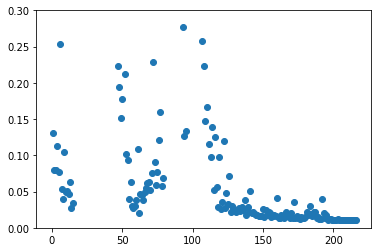

In [56]:
cs = pd.read_csv(logdir, sep=';')
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,0.3)

In [57]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [58]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

In [59]:
test_resultsE.mean()

0.010702079030239502

In [60]:
from tqdm import tqdm

In [61]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [75]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, 
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                print("Compute...")
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits,
                                                None,
                                                pos,
                                                true_info,
                                                edge_size0=226,
                                                edge_size1=112,
                                                use_spmt=False,
                                                time='min',
                                                )
                np.save(test_dir+str(energy)+'data_lpmt_without_noise_sin', data_lpmt)
            else:
                pass
            
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        y_test = true_info[test_column]
        scaler(data_lpmt, y_test)
        preds = np.maximum(model.predict(data_lpmt), 0)
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        sigmas[energy] = np.std(preds - y_test.mean()) / (energy + CONST)
    print("+")
    return sigmas, MSEs, predictions

In [76]:
sigmas, MSEs, predictions = test_sigmas(model, time=True, recompute=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Compute...
Starting cycle...


 10%|█         | 1/10 [00:30<04:37, 30.84s/it]

0.5109988999999999
Compute...
Starting cycle...


 20%|██        | 2/10 [01:28<05:11, 38.98s/it]

1.5109988697622994
Compute...
Starting cycle...


 30%|███       | 3/10 [03:02<06:28, 55.52s/it]

2.5109990065502177
Compute...
Starting cycle...


 40%|████      | 4/10 [05:07<07:36, 76.11s/it]

3.5109988987951803
Compute...
Starting cycle...


 50%|█████     | 5/10 [07:44<08:22, 100.44s/it]

4.510998806956522
Compute...
Starting cycle...


 60%|██████    | 6/10 [10:56<08:32, 128.12s/it]

5.510998686870312
Compute...
Starting cycle...


 70%|███████   | 7/10 [14:21<07:33, 151.15s/it]

6.510998666593649
Compute...
Starting cycle...


 80%|████████  | 8/10 [18:16<05:52, 176.13s/it]

7.510998798899285
Compute...
Starting cycle...


 90%|█████████ | 9/10 [22:48<03:24, 204.91s/it]

8.510999212171052
Compute...
Starting cycle...


100%|██████████| 10/10 [27:41<00:00, 231.43s/it]

9.510998837121212
+


In [77]:
sigmas, MSEs

({0: 0.024079820851990386,
  1: 0.024835007038597534,
  2: 0.019611874601448077,
  3: 0.02172752318247108,
  4: 0.015774901254582526,
  5: 0.015055333279328106,
  6: 0.01854246216464063,
  7: 0.013577445089534701,
  8: 0.012812208168735474,
  9: 0.014192902549396515},
 {0: 0.0022814918422442085,
  1: 0.002546112486784013,
  2: 0.0035131338211720096,
  3: 0.0076379231223810806,
  4: 0.006276280850690025,
  5: 0.008232087348100678,
  6: 0.016967584156795085,
  7: 0.011865632738039159,
  8: 0.013592314283908013,
  9: 0.020233368509410543})

In [78]:
a = 2.8
b=0.59
c=0

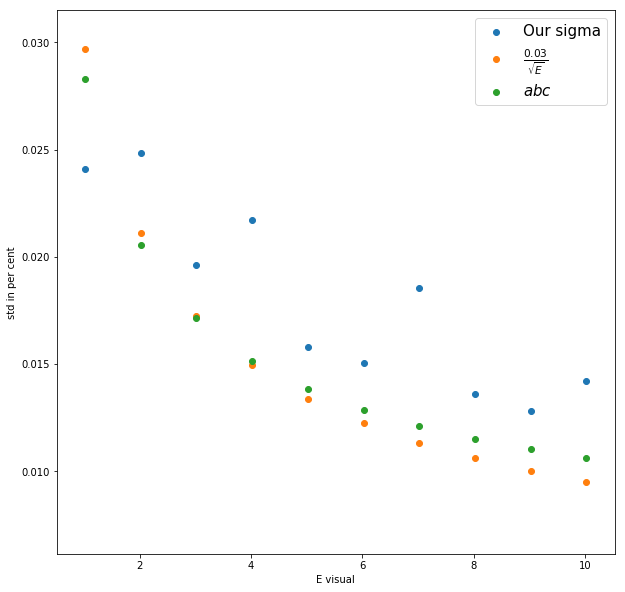

In [79]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)